In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from datetime import datetime
import os
import glob
import shutil
import random
import cv2
from google.colab import drive
import zipfile

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet

In [2]:
# 구글 드라이브와 연동하기
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [3]:
dataset_path = "/content/gdrive/MyDrive/colab_modeling"
DATA_ROOT_DIR = os.path.join("/content", "food")
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "train") # train이라는 폴더를 만들어 주겠다.
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "test")

In [21]:
TRAIN_DATA_ROOT_DIR

'/content/food/train'

In [4]:
# 압축 풀어주기 (풀면 파일이 만들어짐)
with zipfile.ZipFile(os.path.join(dataset_path, "food.zip"), "r") as target_file:
  target_file.extractall(TRAIN_DATA_ROOT_DIR)
    

In [5]:
label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
label_name_list

['sushi', 'pasta', 'porkcutlet', 'chicken', 'burger', 'pizza', 'tteokbokki']

In [6]:
# 실제 이미지를 메모리에 올려놓자

train_data_list = []
train_label_list = []


class_dict = {"sushi" : 0, "pasta" : 1, "porkcutlet" : 2, "chicken" : 3, "burger" : 4, "pizza" : 5, "tteokbokki" : 6}


start_time = datetime.now()
for label_name in label_name_list:
  # file_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
  file_path = TRAIN_DATA_ROOT_DIR + "/" + label_name
  img_file_list = glob.glob(file_path + "/*.*")


# 이미지, 색, 순서(bgr->rgb)
  for img in img_file_list:
    src_img = cv2.imread(img,cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(128,128))
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    train_data_list.append(src_img)
    train_label_list.append(class_dict[label_name])
end_time = datetime.now()
print("Elapsed Time : ", end_time - start_time)

Elapsed Time :  0:00:50.341961


In [7]:
X_train, X_test, y_train, y_test = train_test_split(train_data_list, train_label_list,test_size=0.2, random_state=123, stratify= train_label_list, shuffle=True, )

In [8]:
X_train = np.array(X_train).astype("float32")
y_train = np.array(y_train).astype("float32")

X_test = np.array(X_test).astype("float32")
y_test = np.array(y_test).astype("float32")

In [9]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [10]:
base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(128,128,3))

model = Sequential()
model.add(base_model)

# model.add(Flatten())

model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu')) #은닉층

model.add(Dense(7, activation = 'softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=["accuracy"])
base_model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32) 

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
earlystopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

save_file_name = "/content/food/food_model_Colab.h5"

checkpoint = ModelCheckpoint(save_file_name, monitor="val_loss",verbose=1,
                            save_best_only=True, mode="auto")

result = model.fit(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[earlystopping])


#### 결과 작성
### imagenet, dd 128, adam0.00001, 다중분류
## loss: 0.0066 - accuracy: 0.9994 - val_loss: 0.2899 - val_accuracy: 0.9223

Epoch 1/20
435/435 [==============================] - 42s 68ms/step - loss: 1.1108 - accuracy: 0.6198 - val_loss: 0.5384 - val_accuracy: 0.8342
Epoch 2/20
435/435 [==============================] - 28s 64ms/step - loss: 0.4544 - accuracy: 0.8594 - val_loss: 0.3516 - val_accuracy: 0.8888
Epoch 3/20
435/435 [==============================] - 28s 65ms/step - loss: 0.3170 - accuracy: 0.9019 - val_loss: 0.2840 - val_accuracy: 0.9106
Epoch 4/20
435/435 [==============================] - 29s 66ms/step - loss: 0.2459 - accuracy: 0.9243 - val_loss: 0.2503 - val_accuracy: 0.9221
Epoch 5/20
435/435 [==============================] - 29s 66ms/step - loss: 0.1937 - accuracy: 0.9411 - val_loss: 0.2287 - val_accuracy: 0.9264
Epoch 6/20
435/435 [==============================] - 29s 66ms/step - loss: 0.1552 - accuracy: 0.9544 - val_loss: 0.2146 - val_accuracy: 0.9296
Epoch 7/20
435/435 [==============================] - 29s 66ms/step - loss: 0.1295 - accuracy: 0.9630 - val_loss: 0.2058 - val_accuracy:

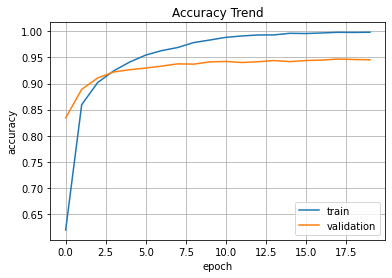

In [18]:
import matplotlib.pyplot as plt

plt.plot(result.history['accuracy'], label='train')
plt.plot(result.history['val_accuracy'], label='validation')
plt.title('Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

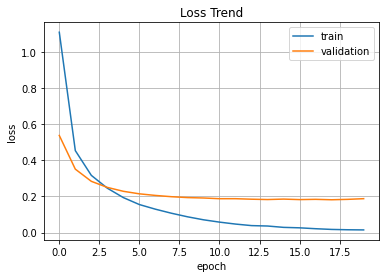

In [19]:
plt.plot(result.history['loss'], label='train')
plt.plot(result.history['val_loss'], label='validation')
plt.title('Loss Trend')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

In [12]:
model.evaluate(X_test, y_test)

### imagenet, dd 128, adam0.00001, 다중분류
## [0.15950730443000793, 0.9475555419921875]

136/136 [==============================] - 3s 18ms/step - loss: 0.2148 - accuracy: 0.9370


[0.2147550880908966, 0.9369969964027405]

In [16]:
test_img2 = cv2.imread("/content/gdrive/MyDrive/colab_modeling/test/3.jpg", cv2.IMREAD_COLOR)
test_img2 = cv2.resize(test_img2, dsize=(128,128))
test_img2 = cv2.cvtColor(test_img2, cv2.COLOR_BGR2RGB)

pred2 = model.predict(test_img2.reshape(-1, 128,128,3))
score2=tf.nn.softmax(pred2)

print("{:.2f}percnet confidence.".format( 100*np.max(score2)))
print(score2)

1/1 [==============================] - 0s 22ms/step
26.59percnet confidence.
tf.Tensor(
[[0.11830278 0.11843404 0.1207592  0.13987416 0.11838443 0.2659429
  0.11830251]], shape=(1, 7), dtype=float32)
